In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import open3d as o3d
import os
import scipy.io
import random
import math
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
images=[]
kp=[]
files=os.listdir('input')
files.sort()
for file in files:
    if file[-4:]=='.jpg':
        images.append(np.array(Image.open('input/'+file)))
    if file[-4:]=='.mat':
        kp.append(scipy.io.loadmat('input/'+file))


In [3]:
ref_image=np.array(Image.open('ref/img_ref.jpg'))
kp_ref=scipy.io.loadmat('ref/kp_ref')

In [4]:
def distance(v0, vref, m):
    d=0
    for i in range(len(v0)):
        d+=(v0[i]-vref[i])**2
        if d>m: return d, False
    return d, True

def getMatches(kpFrame, kpRef):
    _matches=[]
    matches=[]
    indexes=random.choices(range(len(kpFrame['desc'])), k=100)
    desc=kpFrame['desc']
    desc_ref=kpRef['desc']
    kpFrame=kpFrame['kp']
    kpref=kpRef['kp']
    for i in indexes:
        d=desc[i]
        index=-1
        n=100
        for j, _d in enumerate(desc_ref):
            q, flag=distance(d, _d, n)
            if flag and q<n: n=q;index=j;
        _matches.append([n,index])
    for i, j in enumerate(_matches):
        matches.append(np.array(kpref[j[1]].tolist()+kpFrame[indexes[i]].tolist()))#, dtype=np.uint16
    return matches
    
#distance(kp[1]['desc'][0], kp_ref['desc'][0])
#m=getMatches(kp[6], kp[5])


In [5]:
def plot_matches(index, ref, points):
    height2, width2, _ = images[index].shape
    image0_resized = np.array(Image.fromarray(images[ref]).resize((width2, height2)))
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(np.hstack((image0_resized, images[index])))
    for (x1, y1, x2, y2) in points:
        x1=int(x1);y1=int(y1);x2=int(x2);y2=int(y2);
        ax.plot([x1, x2 + width2], [y1, y2], 'r-', alpha=0.2)
        ax.plot(x1, y1, 'bo')
        ax.plot(x2 + width2, y2, 'go')
    plt.show()
#plot_matches(1, 0, random.choices(m, k=15))

In [14]:
def compute_homography_with_RANSAC(index, index_ref):
    print(f'Homography {index} with {index_ref}')
    matches=getMatches(kp[index], kp[index_ref])
    print('\tNº of matches', len(matches))
    n_needed=4
    P=0.99
    p=0.1
    iterations=int(math.log(1-P)/math.log(1-p**n_needed))#72#min(50, int(len(matches)/4))
    max_error=3
    best=[-1,0]#0: nº de inliners; 1: index of inliners
    A=[]
    for i in range(iterations):
        pairs=random.choices(matches, k=n_needed)
        A=[]
        for x,y,xx,yy in pairs:
            #xx=-float(xx) #Avoid Overflow error
            #yy=-float(yy) #Avoid Overflow error
            A.append([x,y,1,0,0,0, -xx*x, -xx*y, -xx])
            A.append([0,0,0,x,y,1, -yy*x, -yy*y, -yy]) 
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        H = Vt[-1].reshape(3, 3)
        inliners=[]
        for j, p in enumerate(matches):
            x,y,xx,yy=p
            w=H@np.array([x,y,1])
            if w[2]==0: continue
            w/=w[2]
            _xx, _yy=w[:2]
            erro=math.sqrt((xx-_xx)**2+(yy-_yy)**2)
            #print(j, xx, yy, _xx, _yy, erro)
            if erro<max_error: 
                inliners.append(j)
        if len(inliners)>best[0]:
            best[0]=len(inliners)
            best[1]=inliners.copy()
            
    print('\tInliners: %.3f %% %d' % (best[0]/len(matches)*100, best[0]))
    inliners=[matches[i] for i in best[1]]
    plot_matches(index, index_ref, inliners)
    A=[]
    for x,y,xx,yy in inliners:
        A.append([x,y,1,0,0,0, -xx*x, -xx*y, -xx])
        A.append([0,0,0,x,y,1, -yy*x, -yy*y, -yy]) 
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3) 
    H/=H[-1][-1]
    return H


Homography 1 with 0
	Nº of matches 100


/tmp/ipykernel_20084/2080390116.py:27: RuntimeWarning: divide by zero encountered in divide
  w/=w[2]
/tmp/ipykernel_20084/2080390116.py:27: RuntimeWarning: invalid value encountered in divide
  w/=w[2]


	Inliners: 20.000 % 20


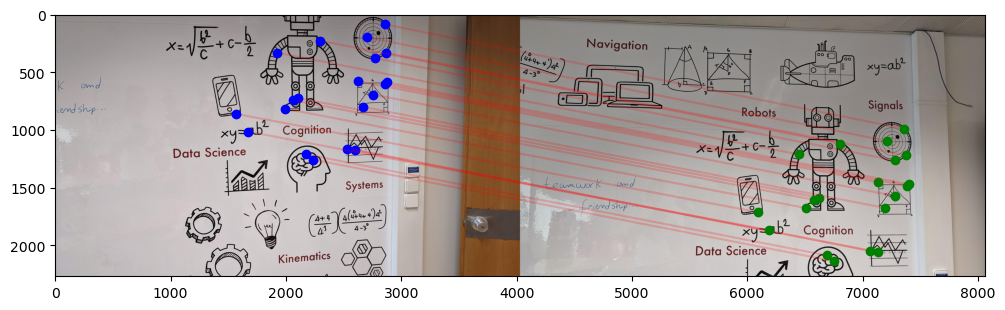

Done image[ 1 ] in 93.624 seconds
Homography 2 with 1
	Nº of matches 100
	Inliners: 16.000 % 16


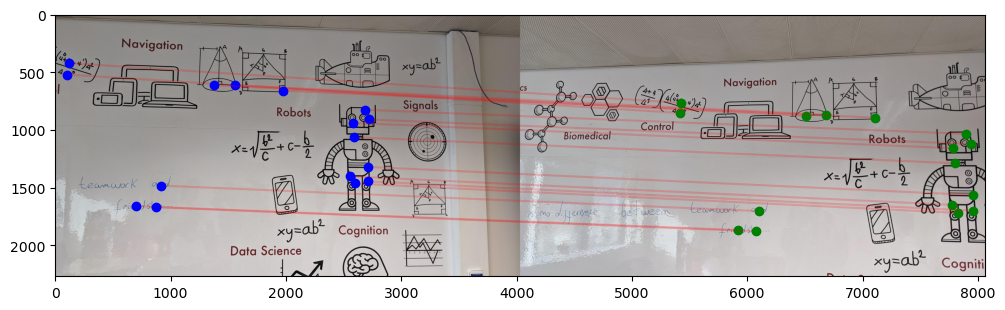

Done image[ 2 ] in 104.342 seconds
Homography 3 with 2
	Nº of matches 100
	Inliners: 20.000 % 20


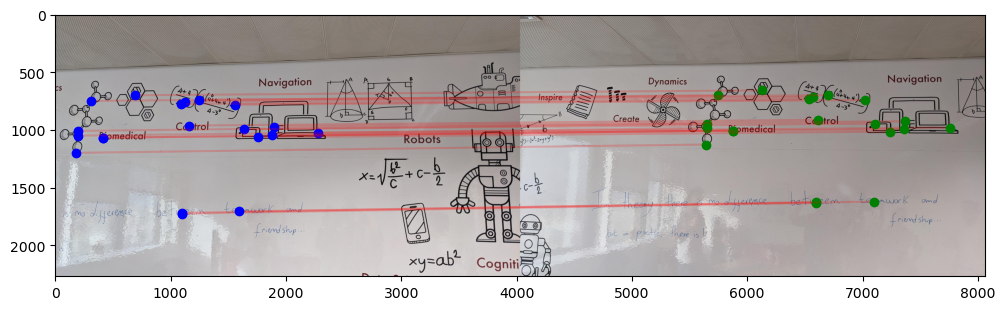

Done image[ 3 ] in 101.513 seconds
Homography 4 with 3
	Nº of matches 100
	Inliners: 13.000 % 13


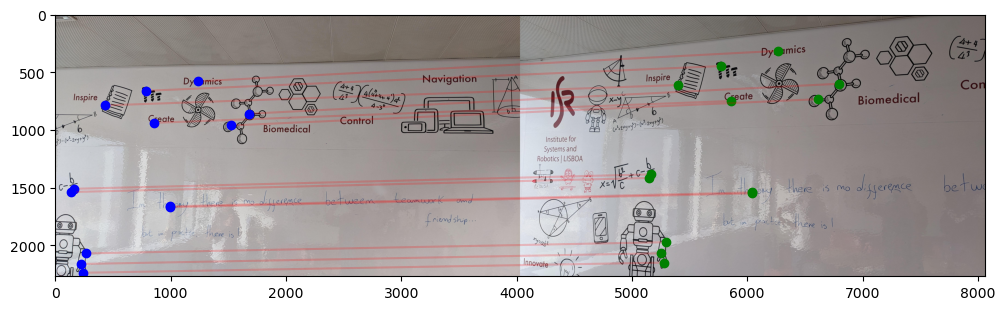

Done image[ 4 ] in 95.345 seconds
Homography 5 with 4
	Nº of matches 100
	Inliners: 12.000 % 12


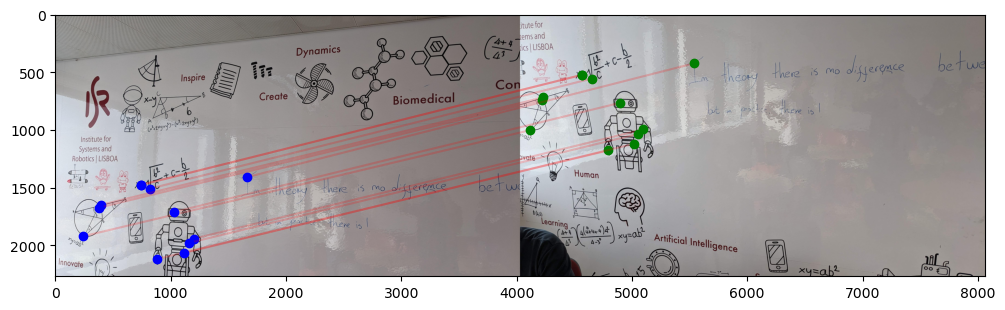

Done image[ 5 ] in 108.798 seconds
Homography 6 with 5
	Nº of matches 100
	Inliners: 9.000 % 9


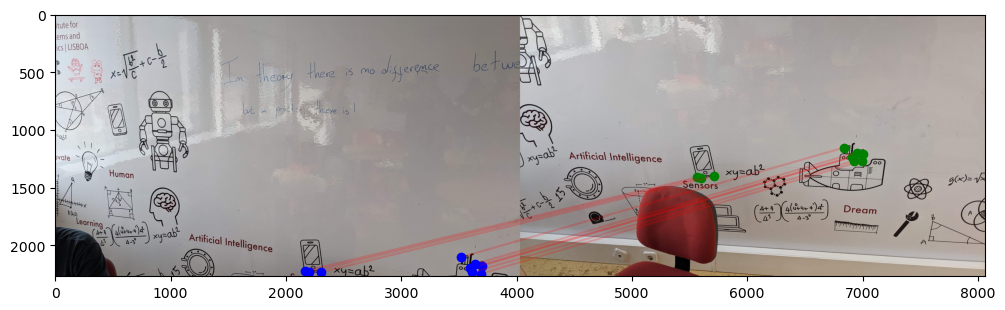

Done image[ 6 ] in 103.013 seconds
Homography 7 with 6
	Nº of matches 100
	Inliners: 8.000 % 8


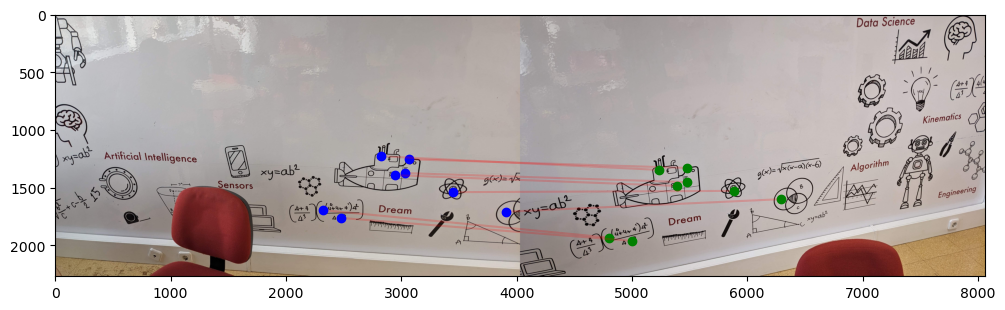

Done image[ 7 ] in 90.511 seconds
Homography 8 with 7
	Nº of matches 100
	Inliners: 18.000 % 18


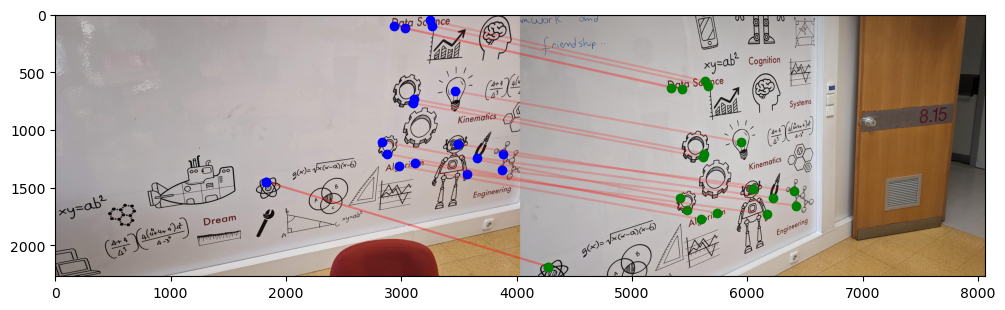

Done image[ 8 ] in 110.581 seconds


In [7]:
Homographies=[]
for i in range(1, len(images)):
    start=time.time()
    Homographies.append(compute_homography_with_RANSAC(i, i-1))
    print('Done image[',i,'] in %.3f seconds' % (time.time()-start))
final_homographies=[]
for i in range(len(Homographies)):
    if i==0:
        final_homographies.append(Homographies[0])
    else:
        final_homographies.append(Homographies[i-1]*Homographies[i])

Homography 8 with 0
	Nº of matches 100
	Inliners: 9.000 % 9


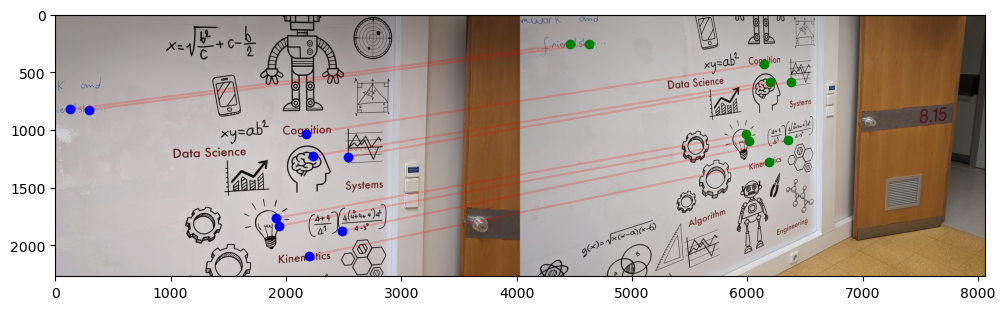

[[ 1.14033952e+00  1.40548249e-01  1.99019137e+02]
 [ 2.85804891e-02  1.14082818e+00 -6.71367064e+02]
 [ 1.27623174e-04  5.44794237e-05  1.00000000e+00]]
[[ 3.30458655e+00  8.83587343e-02  1.24869527e+07]
 [-8.24304934e-04  2.21951927e+00  1.45848877e+05]
 [ 3.55961559e-08 -9.23078338e-10  1.00000000e+00]]


In [8]:
H8=compute_homography_with_RANSAC(8, 0)
print(H8)
print(final_homographies[-1])

In [13]:
v=final_homographies[-1]@np.array([2500,2000,1])
v/=v[-1]
v

array([1.24943020e+07, 1.50272759e+05, 1.00000000e+00])